# Notebook 1: Protocolo de Extracción de Datos y Preparación del Dataset (Sampling)
## Proyecto: Evaluación de Riesgo Arqueológico mediante Machine Learning
**Caso de Estudio:** Modelo Predictivo de Probabilidad de Hallazgos en el Territorio Peruano

**Autor:** Yishar Piero Nieto Barrientos  
**Repositorio de Investigación:** [Tu enlace de GitHub aquí]

---

### **Introducción**
Este notebook constituye la fase inicial del flujo de trabajo de **Ingeniería de Características (Feature Engineering)** aplicado a la arqueología preventiva[cite: 7]. El objetivo central es la transformación de datos geoespaciales continuos (Rasters) en una estructura de datos tabular (Dataframe) apta para algoritmos de aprendizaje supervisado[cite: 48, 58].

Mediante la técnica de **"Pixel Drilling"** o muestreo puntual multivariable, se extraen los valores de variables biofísicas y culturales en coordenadas específicas[cite: 50, 57]. Este proceso permite que el modelo identifique patrones de asentamiento basados en la habitabilidad y la proximidad a recursos estratégicos[cite: 19, 20].

### **Especificaciones Técnicas**
* **Resolución Espacial:** 30 x 30 metros por píxel, asegurando un balance entre precisión geográfica y eficiencia computacional.
* **Estrategia de Optimización:** Pre-cálculo de distancias euclidianas y variables derivadas en entorno GIS (Rasterización previa) para acelerar la inferencia en Python[cite: 4, 5, 6].
* **Variables Predictoras:** Topografía (Pendiente, Rugosidad), Hidrografía (Ríos, Lagos) y Redes Culturales (Qhapaq Ñan, Sitios Declarados)[cite: 21, 24, 28, 35, 39].

### **1. Instalacion de librerias**
Instalamos las librerías necesarias para el manejo de rasters y modelos predictivos.

In [1]:
import os
import sys
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Esto es para que los mapas se vean bonitos dentro del notebook
%matplotlib inline

print("Entorno configurado correctamente.")

ModuleNotFoundError: No module named 'seaborn'

### **2. Inventario de Variables y Fuentes de Datos**
Para garantizar la validez del modelo predictivo, se han seleccionado variables que responden a criterios de habitabilidad, acceso a recursos y conectividad arqueológica. Cada capa ha sido procesada con una resolución de 30 metros.

| Categoría | Capa Raster (.tif) | Descripción Técnica | Justificación Arqueológica |
| :--- | :--- | :--- | :--- |
| **Topografía** | `pendiente_calca.tif` | Inclinación del terreno en grados. | Define áreas aptas para construcción y agricultura. |
| **Topografía** | `rugosidad_calca.tif` | Índice de Rugosidad del Terreno (TRI). | Identifica la complejidad del relieve y transitabilidad. |
| **Hidrografía**| `dis_rios_calca.tif` | Distancia euclidiana a redes hídricas. | Recurso vital para el sustento y comunicación. |
| **Hidrografía**| `dis_lagos_calca.tif` | Distancia a cuerpos hídricos lénticos. | Zonas de captación de recursos y posible carácter ritual. |
| **Cultura** | `dis_qhapaq.tif` | Proximidad a la red vial incaica. | Eje de articulación territorial y hallazgos asociados |
| **Evidencia** | `dis_declarados.tif` | Distancia a sitios arqueológicos registrados. | Probabilidad aumentada por recurrencia de ocupación. |

In [23]:
# Lista de archivos basada en tu tabla de variables
archivos_raster = [
    '../data/raw/pendiente_calca.tif',
    '../data/raw/rugosidad_calca.tif',
    '../data/raw/dis_rios_calca.tif',
    '../data/raw/dis_lagos_calca.tif',
    '../data/raw/dis_qhapaq.tif',
    '../data/raw/dis_declarados.tif',
    '../data/raw/dis_g1.tif',
    '../data/raw/dis_g2.tif',
    '../data/raw/dis_g2.tif'
]

print("--- Verificando Fuentes de Datos Geoespaciales ---")
for ruta in archivos_raster:
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            # Validamos que la resolución sea de 30m como dice tu texto
            res_x, res_y = src.res
            print(f" {os.path.basename(ruta)} | Res: {res_x}m | CRS: {src.crs}")
    else:
        print(f"ADVERTENCIA: No se encontró el archivo en: {ruta}")

--- Verificando Fuentes de Datos Geoespaciales ---
 pendiente_calca.tif | Res: 29.991099562363246m | CRS: None
 rugosidad_calca.tif | Res: 29.991099562363246m | CRS: None
 dis_rios_calca.tif | Res: 30.0m | CRS: EPSG:32719
 dis_lagos_calca.tif | Res: 30.0m | CRS: EPSG:32719
 dis_qhapaq.tif | Res: 30.0m | CRS: EPSG:32719
 dis_declarados.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g1.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g2.tif | Res: 30.0m | CRS: EPSG:32719
 dis_g2.tif | Res: 30.0m | CRS: EPSG:32719


#### **2.1 Visualizacion y validacion de capas topograficas**
Realizamos una carga ligera de cada variable para confirmar su integridad estructural y espacial antes del procesamiento masivo.

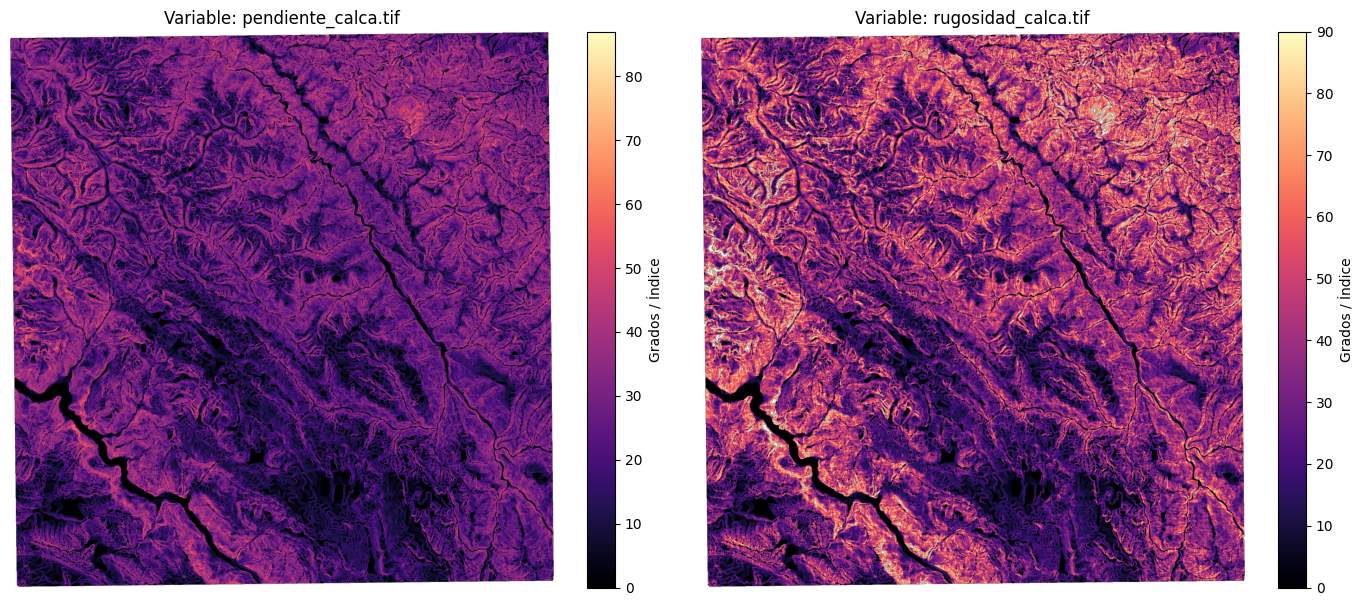

In [25]:
# Definimos las capas topográficas
capas_topografia = ['../data/raw/pendiente_calca.tif', '../data/raw/rugosidad_calca.tif']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ruta in enumerate(capas_topografia):
    with rasterio.open(ruta) as src:
        data = src.read(1)
        # Filtramos valores fuera de rango para recuperar el relieve
        data_filtrada = np.where((data < 0) | (data > 90), np.nan, data)
        
        im = axes[i].imshow(data_filtrada, cmap='magma')
        plt.colorbar(im, ax=axes[i], label='Grados / Índice')
        axes[i].set_title(f"Variable: {os.path.basename(ruta)}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

#### **2.2 Visualizacion y validacion de capas de distancia**

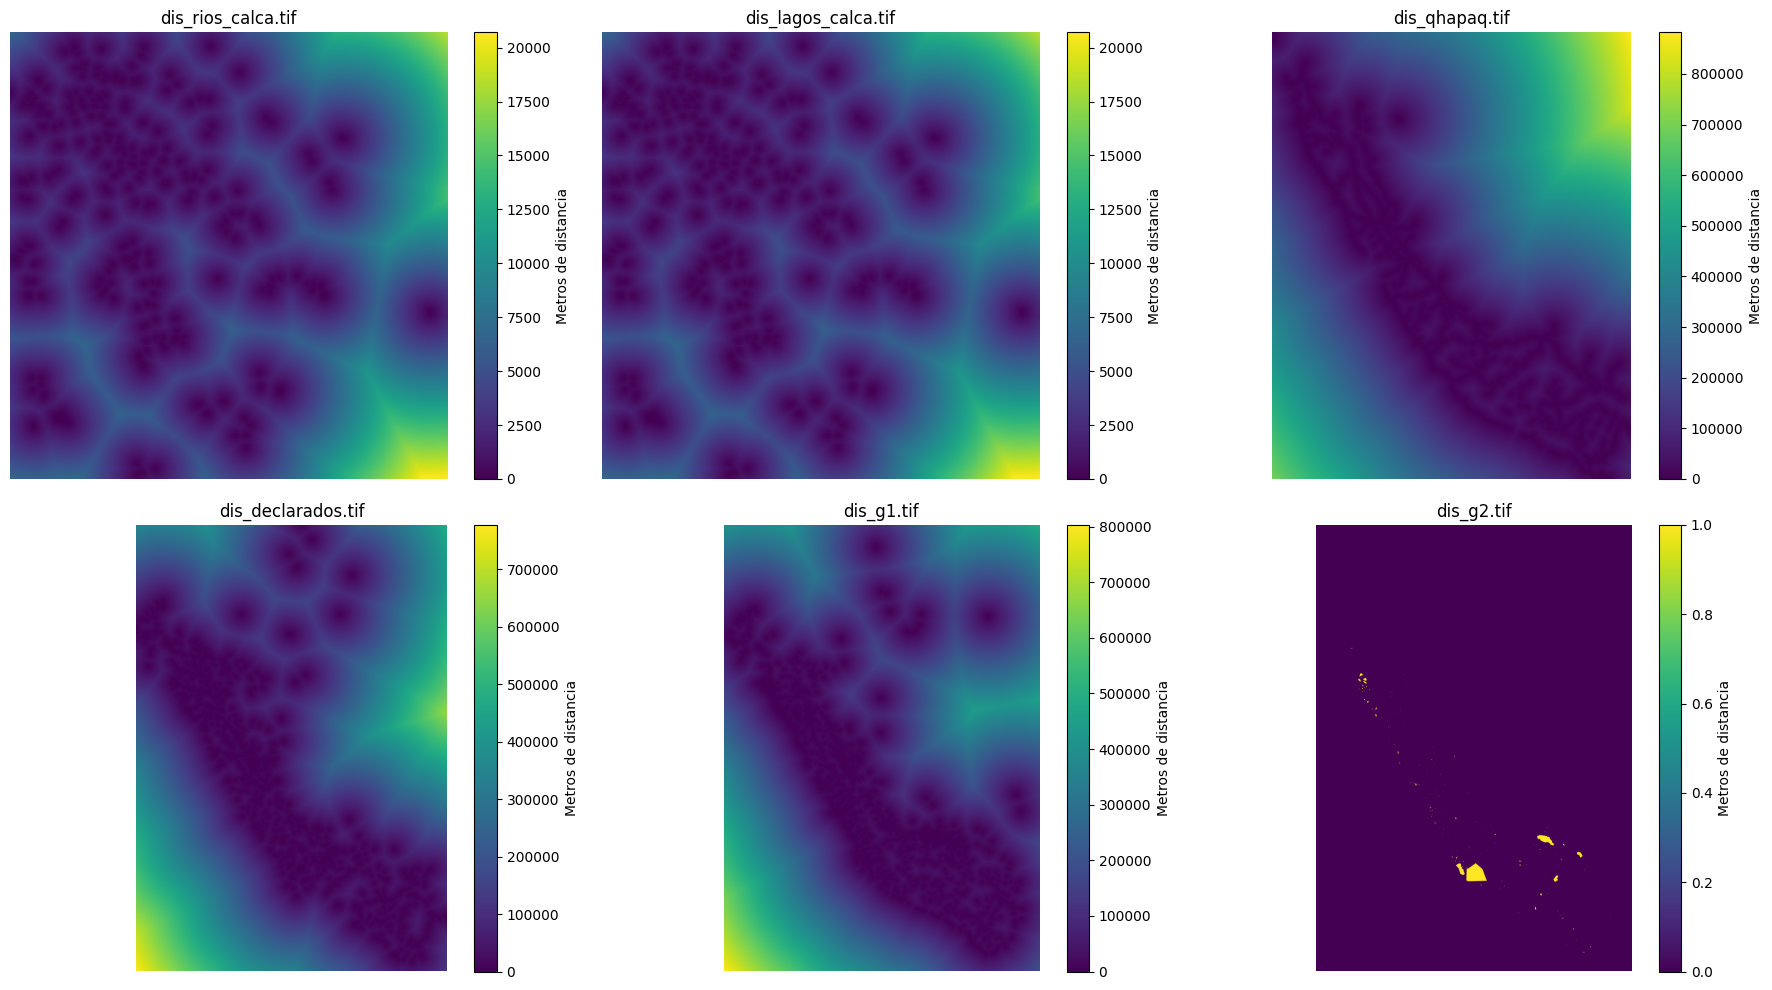

In [26]:
# Definimos las capas de distancia (excluyendo las de terreno)
capas_distancia = [
    '../data/raw/dis_rios_calca.tif', '../data/raw/dis_lagos_calca.tif',
    '../data/raw/dis_qhapaq.tif', '../data/raw/dis_declarados.tif',
    '../data/raw/dis_g1.tif', '../data/raw/dis_g2.tif'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, ruta in enumerate(capas_distancia):
    with rasterio.open(ruta) as src:
        # Lectura ligera para no saturar memoria (58GB)
        data = src.read(1, out_shape=(1, int(src.height // 10), int(src.width // 10)))
        
        # Usamos viridis para diferenciar claramente las distancias
        im = axes[i].imshow(data, cmap='viridis')
        plt.colorbar(im, ax=axes[i], label='Metros de distancia')
        axes[i].set_title(os.path.basename(ruta))
        axes[i].axis('off')

plt.tight_layout()
plt.show()

#### **3. Preprocesamiento: Armonizacion de proyecciones CRS**

#### **4. Analisis Exploratorio de datos (EDA)**
En esta etapa, transformamos los datos espaciales en datos estadísticos. Dado que manejamos un volumen de 58 GB, utilizaremos un muestreo aleatorio sistemático para obtener una representación estadísticamente significativa sin agotar los recursos de memoria RAM.

In [ ]:
# Definimos una función para extraer una muestra aleatoria de los rasters
def extraer_muestra(archivos, n_muestras=10000):
    datos = {}
    for ruta in archivos:
        # Usamos los archivos corregidos en 'processed' si existen, sino los 'raw'
        ruta_proc = ruta.replace('raw', 'processed').replace('.tif', '_fixed.tif')
        ruta_final = ruta_proc if os.path.exists(ruta_proc) else ruta
        
        with rasterio.open(ruta_final) as src:
            # Leemos la banda 1 y aplanamos el array
            banda = src.read(1).flatten()
            # Filtramos valores NoData (asumimos 0 o negativos para distancias/pendientes)
            banda = banda[banda > 0]
            # Tomamos una muestra aleatoria
            datos[os.path.basename(ruta)] = np.random.choice(banda, n_muestras)
    
    return pd.DataFrame(datos)

# Extraemos los datos (esto es rápido y seguro para tu RAM)
df_muestra = extraer_muestra(archivos_raster)